In [248]:
# Model of AEME
# File: model.py
# Author: Cong Bao

from __future__ import division

from abc import ABCMeta, abstractmethod
from itertools import combinations

import numpy as np
import sklearn.preprocessing as skpre
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 


__author__ = 'Cong Bao'

class AEME(object):
    """ Autoencoded Meta-Embedding.
        :param input_list: a list of source embedding path
        :param output_path: a string path of output file
        :param log_path: a string path of log file
        :param ckpt_path: a string path of checkpoint file
        :param model_type: the type of model, among DAEME, CAEME, AAEME
        :param dims: a list of dimensionalities of each source embedding
        :param learning_rate: a float number of the learning rate
        :param batch_size: a int number of the batch size
        :param epoch: a int number of the epoch
        :param activ: a string name of activation function
        :param factors: a list of coefficients of each loss part
        :param noise: a float number between 0 and 1 of the masking noise rate
        :param emb_dim: a int number of meta-embedding dimensionality, only used in AAEME model
        :param oov: a boolean value whether to initialize inputs with oov or not
        :param restore: a boolean value whether to restore checkpoint from local file or 
        :property logger: a logger to record log information
        :property utils: a utility tool for I/O
        :property sess: a tensorflow session
        :property ckpt: a tensorflow saver 
    """

    def __init__(self, **kwargs):
        self.model_type = kwargs['model']
        self.dims = kwargs['dims']
        self.learning_rate = kwargs['learning_rate']
        self.batch_size = kwargs['batch']
        self.epoch = kwargs['epoch']
        self.activ = kwargs['activ']
        self.factors = kwargs['factors']
        self.noise = kwargs['noise']
        self.emb_dim = kwargs['emb']
        self.oov = kwargs['oov']
        self.ckpt_path = kwargs['ckpt'] + 'model.ckpt'

        self.sess = tf.Session()
        self.ckpt = None

    def load_data(self, src_dict_list):
        """ Load individual source embeddings and store intersection/union words and embeddings in separate lists.
            If oov is True, word list will be the union of individual vocabularies.
            If oov is False, word list will be the intersection of individual vocabularies.
        """

        self.inter_words = list(set.intersection(*[set(src_dict.keys()) for src_dict in src_dict_list]))
        print('Intersection Words: %s' % len(self.inter_words))
        self.sources = np.asarray(list(zip(*[skpre.normalize([src_dict[word] for word in self.inter_words]) for src_dict in src_dict_list])))
       
        # delete the list of dicts to release memory
        del src_dict_list

    def build_model(self):
        """ Build the model of AEME.
            The model to build will be one of DAEME, CAEME, or AAEME.
        """
        # initialize sources and inputs
        self.srcs = [tf.placeholder(tf.float32, (None, dim)) for dim in self.dims]
        self.ipts = [tf.placeholder(tf.float32, (None, dim)) for dim in self.dims]
        # select and build models
        params = [self.dims, self.activ, self.factors]
        if self.model_type == 'DAEME':
            self.aeme = DAEME(*params)
        elif self.model_type == 'CAEME':
            self.aeme = CAEME(*params)
        elif self.model_type == 'AAEME':
            self.aeme = AAEME(*params, emb_dim=self.emb_dim)
        self.aeme.build(self.srcs, self.ipts)

    def train_model(self):
        """ Train the model.
            Variables with least losses will be stored in checkpoint file.
        """
        step = tf.Variable(0, trainable=False)
        rate = tf.train.exponential_decay(self.learning_rate, step, 50, 0.99)
        loss = self.aeme.loss()
        opti = tf.train.AdamOptimizer(rate).minimize(loss, global_step=step)
        self.ckpt = tf.train.Saver(tf.global_variables())
        self.sess.run(tf.global_variables_initializer())
        size = len(self.sources) // self.batch_size # the number of batches
        best = float('inf')
        # loop for N epoches
        for itr in range(self.epoch):
            indexes = np.random.permutation(len(self.sources)) # shuffle training inputs
            train_loss = 0.
            # train with mini-batches
            for idx in range(size):
                batch_idx = indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
                batches = list(zip(*self.sources[batch_idx]))
                feed = {k:v for k, v in zip(self.srcs, batches)}
                feed.update({k:self._corrupt(v) for k, v in zip(self.ipts, batches)})
                _, batch_loss = self.sess.run([opti, loss], feed)
                train_loss += batch_loss
            epoch_loss = train_loss / size
            # save the checkpoint with least loss
            if epoch_loss <= best:
                self.ckpt.save(self.sess, self.ckpt_path)
                best = epoch_loss
#             print('[Epoch{0}] loss: {1}'.format(itr, epoch_loss))

    def generate_meta_embed(self):
        """ Generate meta-embedding and save as local file.
            Variables used to predict are these with least losses during training.
        """
        embed= {}
        print('Generating meta embeddings...')
        self.ckpt.restore(self.sess, self.ckpt_path)
        if self.oov:
            vocabulary = self.union_words
        else:
            vocabulary = self.inter_words
        for i, word in enumerate(vocabulary):
            meta = self.sess.run(self.aeme.extract(), {k:[v] for k, v in zip(self.ipts, self.sources[i])})
            embed[word] = np.reshape(meta, (np.shape(meta)[1],))
        self.sess.close()
        del self.sources
        return embed

    def _corrupt(self, batch):
        """ Corrupt a batch using masking noises.
            :param batch: the batch to be corrupted
            :return: a new batch after corrupting
        """
        noised = np.copy(batch)
        batch_size, feature_size = np.shape(batch)
        for i in range(batch_size):
            mask = np.random.randint(0, feature_size, int(feature_size * self.noise))
            for m in mask:
                noised[i][m] = 0.
        return noised

class AbsModel(object):
    """ Base class of all proposed methods.
        :param dims: a list of dimensionalities of each input
        :param activ: the string name of activation function
        :param factors: a list of coefficients of each loss part
    """

    __metaclass__ = ABCMeta

    def __init__(self, dims, activ, factors):
        self.dims = dims
        self.factors = factors

        if activ == 'lrelu':
            self.activ = tf.keras.layers.LeakyReLU(0.2)
        elif activ == 'prelu':
            self.activ = tf.keras.layers.PReLU()
        else:
            self.activ = tf.keras.layers.Activation(activ)

        self.meta = None

    @staticmethod
    def mse(x, y, f):
        """ Mean Squared Error with slicing.
            This method will slice vector with higher dimension to the lower one,
            if the two vector have different dimensions.
            :param x: first vector
            :param y: second vector
            :param f: coefficient
            :return: a tensor after calculating f * (1 / d) * ||x - y||^2
        """
        x_d = x.get_shape().as_list()[1]
        y_d = y.get_shape().as_list()[1]
        if x_d != y_d:
            smaller = min(x_d, y_d)
            x = tf.slice(x, [0, 0], [tf.shape(x)[0], smaller])
            y = tf.slice(y, [0, 0], [tf.shape(y)[0], smaller])
        return tf.scalar_mul(f, tf.reduce_mean(tf.squared_difference(x, y)))

    def extract(self):
        """ Extract the meta-embeddding model.
            :return: the meta-embedding model
        """
        return self.meta

    @abstractmethod
    def build(self, srcs, ipts):
        """ Abstract method.
            Build the model.
            :param srcs: source embeddings
            :param ipts: input embeddings
        """
        self.srcs = srcs
        self.ipts = ipts

    @abstractmethod
    def loss(self):
        """ Abstract method.
            Obtain the loss function of model.
            :return: a tensor calculating the loss function
        """
        pass

class DAEME(AbsModel):
    """ Decoupled Autoencoded Meta-Embedding.
        This method calculate meta-embedding as the concatenation of encoded source embeddings.
        The loss function is defined as the sum of mse of each autoencoder and the mse between meta parts.
    """

    def build(self, srcs, ipts):
        AbsModel.build(self, srcs, ipts)
        self.encoders = [tf.layers.dense(ipt, dim, self.activ) for ipt, dim in zip(self.ipts, self.dims)]
        self.meta = tf.nn.l2_normalize(tf.concat(self.encoders, 1), 1)
        self.outs = [tf.layers.dense(encoder, dim) for encoder, dim in zip(self.encoders, self.dims)]

    def loss(self):
        los = tf.add_n([self.mse(x, y, f) for x, y, f in zip(self.srcs, self.outs, self.factors[:-1])])
        for x, y in combinations(self.encoders, 2):
            los = tf.add(los, self.mse(x, y, self.factors[-1]))
        return los

class CAEME(AbsModel):
    """ Concatenated Autoencoded Meta-Embedding.
        This method calculate meta-embedding as the concatenation of encoded source embeddings.
        The loss function is defined as the sum of mse of each autoencoder.
    """

    def build(self, srcs, ipts):
        AbsModel.build(self, srcs, ipts)
        self.encoders = [tf.layers.dense(ipt, dim, self.activ) for ipt, dim in zip(self.ipts, self.dims)]
        self.meta = tf.nn.l2_normalize(tf.concat(self.encoders, 1), 1)
        self.outs = [tf.layers.dense(self.meta, dim) for dim in self.dims]

    def loss(self):
        return tf.add_n([self.mse(x, y, f) for x, y, f in zip(self.srcs, self.outs, self.factors)])

class AAEME(AbsModel):
    """ Averaged Autoencoded Meta-Embedding.
        This method calculate meta-embedding as the averaging of encoded source embeddings.
        The loss function is defined as the sum of mse of each autoencoder.
        :param emb_dim: the dimensionality of meta-embedding
    """

    def __init__(self, *args, **kwargs):
        AbsModel.__init__(self, *args)
        self.emb_dim = kwargs['emb_dim']

    def build(self, srcs, ipts):
        AbsModel.build(self, srcs, ipts)
        self.encoders = [tf.layers.dense(ipt, self.emb_dim, self.activ) for ipt in self.ipts]
        self.meta = tf.nn.l2_normalize(tf.add_n(self.encoders), 1)
        self.outs = [tf.layers.dense(self.meta, dim) for dim in self.dims]

    def loss(self):
        return tf.add_n([self.mse(x, y, f) for x, y, f in zip(self.srcs, self.outs, self.factors)])


In [249]:
def get_single_model_corpus_mean_dict(model):
    
    ds = []
    # read all dicts
    for split in ['train', 'valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']:

        d = read_dataset("elmo", "remote_homology", split)   
        ds.append(d)

    all_d = {}
    
    for d in ds:
        for k in list(d.keys()):
            seq = d[k]
            all_d[k] = np.mean(seq, axis=0)

    return all_d


In [266]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from scipy.sparse import csr_matrix

def spy_vis(arr, title_str=''):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    ax = fig.add_subplot(111)
    ax.spy(arr)
    plt.title(title_str)
    plt.ylabel("Sample")
    plt.xlabel("Embedding Space")
    ax.set_aspect(aspect=0.2)
    plt.show()

def dict_to_arr_any(embeded_corpus):
    emb_shape = list(embeded_corpus.values())[0].shape
    number_of_embeddings = len(embeded_corpus) 

    embeded_corpus_arr = np.zeros((number_of_embeddings, emb_shape[-1]))

    i = 0
    keys = list(embeded_corpus.keys())
    keys.sort()
    for key in keys :
        embeded_corpus_arr[i] = embeded_corpus[key]
        i += 1
    
    return embeded_corpus_arr


In [251]:
from read_scripts import read_dataset 

e_dict = get_single_model_corpus_mean_dict("elmo")
t_dict = get_single_model_corpus_mean_dict("transformer")
u_dict = get_single_model_corpus_mean_dict("unirep")

list_emb_dicts = [e_dict, t_dict, u_dict]

In [273]:
dims = []
for d in list_emb_dicts:
    dims.append(list(d.values())[0].shape[0])
    
params = {}
params['model'] = 'DAEME' # among DAEME, CAEME, AAEME
params['emb'] = 200 # a int number of meta-embedding dimensionality, only used in AAEME model
params['dims'] = dims # a list of encoded dimensionalities for each source embedding
params['learning_rate'] = 0.001
params['batch'] = 128
params['epoch'] = 200
params['activ'] = 'relu'
params['factors'] = [1.0, 1.0, 1.0]
params['noise'] = 0.00
params['oov'] = False
params['ckpt'] = './aeme'

emebed with l1= 0.0
Intersection Words: 16281
Generating meta embeddings...
INFO:tensorflow:Restoring parameters from ./aememodel.ckpt


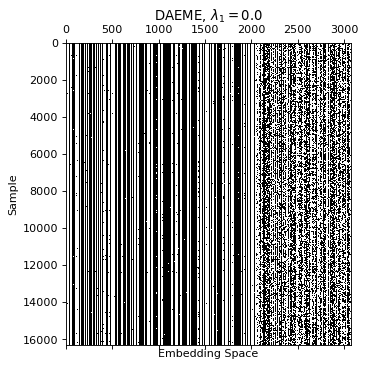

emebed with l1= 0.5
Intersection Words: 16281


KeyboardInterrupt: 

In [274]:
l1s = [0.0, 0.5, 1.0, 1.5, 2.0]
sparsities = []

for l1 in l1s:
    print("emebed with l1=",l1)
    params['factors'] = [1.0, 1.0, l1]
    aeme = AEME(**params)
    aeme.load_data(list_emb_dicts)
    aeme.build_model()
    aeme.train_model()
    embeded = aeme.generate_meta_embed()
    embeded = dict_to_arr_any(embeded)
    
    sparsity = 1.0 - ( np.count_nonzero(embeded) / float(embeded.size) )
    sparsities.append(sparsity)
    
    spy_vis(embeded, f"DAEME, $\lambda_1 = {l1}$")

In [134]:
from sklearn.linear_model import LogisticRegression
from timeit import default_timer as timer
from datetime import timedelta
import os
from sklearn import preprocessing
import numpy as np
from read_scripts import dict_2_arr 
from read_scripts import read_dataset 
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

task = "remote_homology"

def fit_logistic(X, y):
    start = timer()
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X, y)
    end = timer()
    print(f"fit time: ", timedelta(seconds=end-start))
    
    train_score = clf.score(X, y)
    print(f"model train score: ", train_score)
    
    # when run will play a ping sound!
    os.system("printf '\a'")
    os.system("printf '\a'")
    os.system("printf '\a'")
    print("Done!")
    
    return clf

In [135]:
def dict_2_arr(data_dict, labels, avgr=lambda x: np.mean(x, axis=0)):
    
    emb_shape = list(data_dict.values())[0].shape
    number_of_embeddings = len(labels) 

    X = np.zeros((number_of_embeddings, emb_shape[-1]))
    y = np.zeros(number_of_embeddings)
    
    i = 0

    # iter over sorted keys in labels to ensure proteins
    # from different models are indexed the same
    keys = list(labels.keys())
    keys.sort()
    for key in keys :
        if key == 'd1smyc_':
            continue
        X[i] = avgr(data_dict[key])
        y[i] = labels[key]
        i += 1
        
    return X, y


def train_test_over_corpus_dict(corpus, model_name):

    all_score = {}
    labels = {}
    
    # read all labels
    for split in ['train', 'valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']:
        labels[split] = read_dataset("label", "remote_homology", split)   

    y_train_dict = labels['train']
    X_train, y_train = dict_2_arr(corpus, labels['train'], avgr=lambda x: x)
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # fit!
    clf = fit_logistic(X_train, y_train)

    # record train score
    print(X_train.shape, y_train.shape)
    train_score = clf.score(X_train, y_train)
    print(f"{model_name} train score: ", train_score)

    all_score["train"]  = train_score

    # get slices for remaing splits and score
    remain_splits = ['valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']
    for split in remain_splits:
        
        y_dict = labels[split]
        X, y = dict_2_arr(corpus, labels[split], avgr=lambda x: x)
        X = scaler.transform(X)
        
        print(split, X.shape, y.shape)
        test_score = clf.score(X, y)

        all_score[split]  = test_score

        print(f"{model_name} {split} score: ", test_score)

    return all_score, clf

In [136]:
scores, clf = train_test_over_corpus_dict(embeded_corpus, "CAEME_test")

fit time:  0:28:09.303962
model train score:  1.0
Done!
(12305, 3072) (12305,)
CAEME_test train score:  1.0
valid (734, 3072) (734,)
CAEME_test valid score:  0.36239782016348776
test_fold_holdout (718, 3072) (718,)
CAEME_test test_fold_holdout score:  0.24651810584958217
test_superfamily_holdout (1252, 3072) (1252,)
CAEME_test test_superfamily_holdout score:  0.44329073482428116
test_family_holdout (1272, 3072) (1272,)
CAEME_test test_family_holdout score:  0.9316037735849056


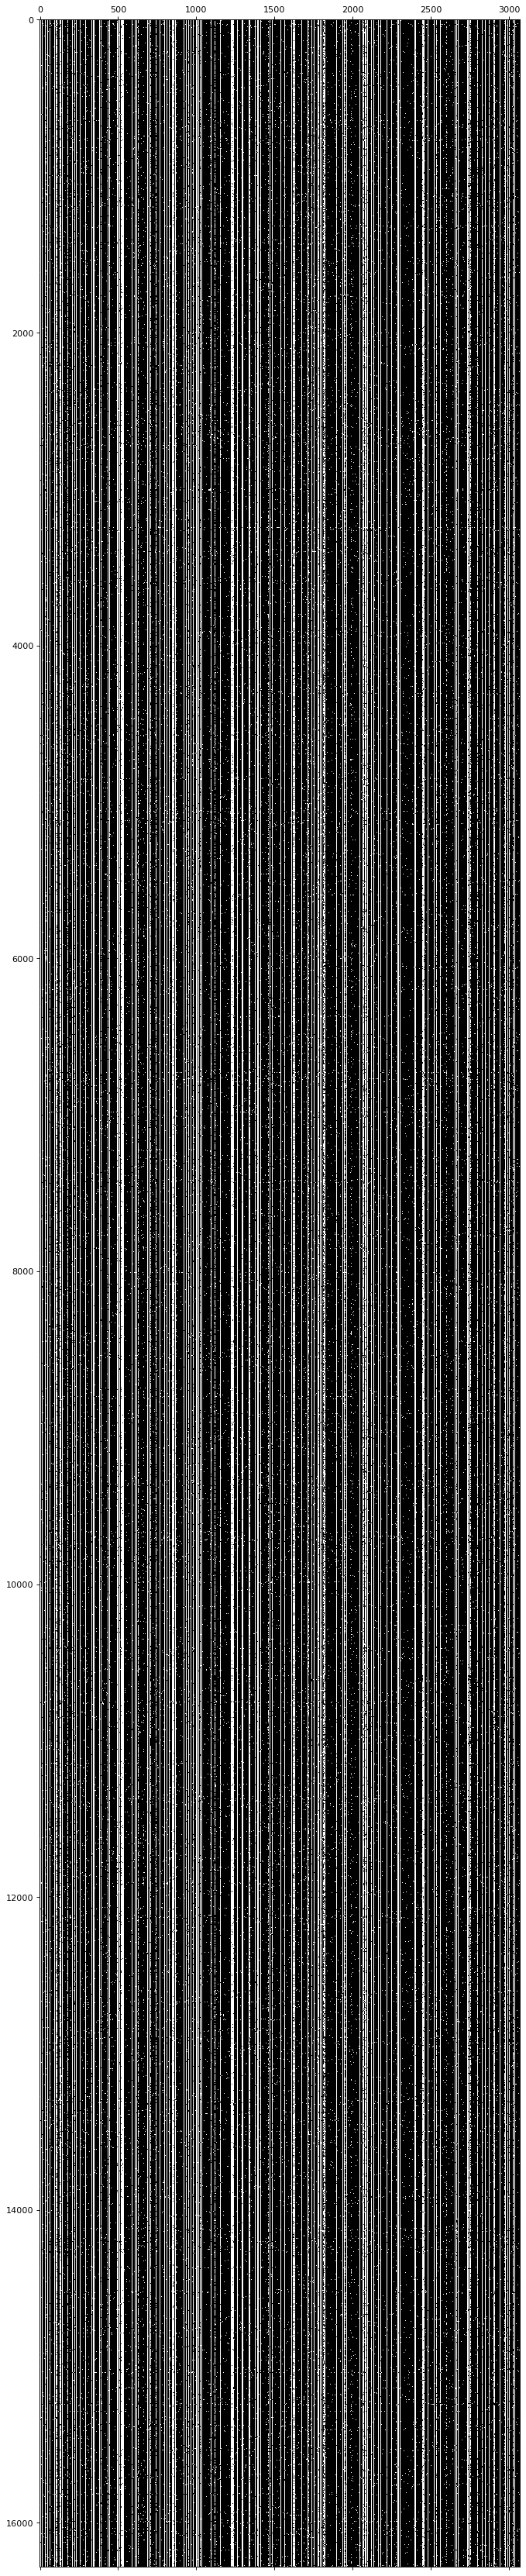

In [173]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 100), dpi=80)

plt.spy(embeded_corpus_arr) 

In [158]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3000, n_iter=10, random_state=1)
svd.fit(embeded_corpus_arr)
TruncatedSVD(n_components=5, n_iter=7, random_state=1)
print(svd.explained_variance_ratio_)


[7.07309543e-03 9.49816634e-02 6.85110657e-02 ... 1.69410083e-09
 1.58437678e-09 1.43372177e-09]


0.9999999924569749


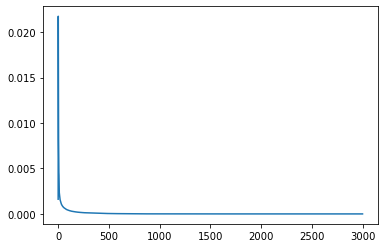

In [161]:
print(svd.explained_variance_ratio_.sum())
plt.plot(svd.explained_variance_)

[0.028493   0.02080527 0.02081905 ... 0.02661343 0.01347362 0.01558075]


AttributeError: 'AxesSubplot' object has no attribute 'set_color'

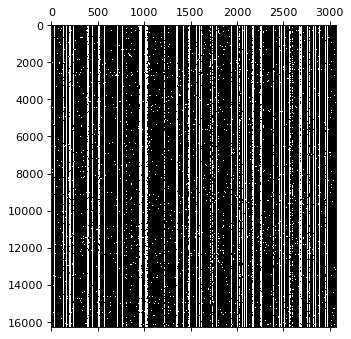